Clustering algorithms in MLlib: k-means is one of the most commonly used clustering algorithms that clusters the data points into a predefined number of clusters.

# Set up

In [1]:
#read in file as dataframe 
# import pyspark modules
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *       # for datatype conversion
from pyspark.sql.functions import *   # for col() function
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas as pd
import os
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml import Pipeline
import pyspark.sql.types as typ
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, Row
from pyspark.ml.feature import OneHotEncoder, StringIndexer, Bucketizer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
import pyspark.mllib.regression as reg
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.linalg import SparseVector, DenseVector
import functools 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
from pyspark.sql import SparkSession 
spark = SparkSession \
    .builder \
    .master("local") \
    .appName("app") \
    .config("spark.executor.memory", '2g') \
    .config('spark.executor.cores', '2') \
    .config('spark.cores.max', '2') \
    .config("spark.driver.memory",'4g') \
    .getOrCreate()

sc = SparkContext.getOrCreate()
sqlCtx = SQLContext(sc)

In [3]:
path_to_data = os.path.join("/home/jovyan/FlightDelay/clean_data_no_hot_2.dms")

In [4]:
df = spark.read.format("csv") \
    .option("header", "true").option("inferschema","true").load(path_to_data)

# one hot encoder 

In [5]:
# for each level, count freq. val=0 for most freq, then 1, ...

stringIndexer = StringIndexer(inputCol="AIRLINE", outputCol="AIRLINE_Index")
model = stringIndexer.fit(df)
indexed = model.transform(df)

encoder = OneHotEncoder(inputCol="AIRLINE_Index", outputCol="AIRLINE_Vec")
encoded = encoder.transform(indexed)

In [6]:
# for each level, count freq. val=0 for most freq, then 1, ...

stringIndexer2 = StringIndexer(inputCol="ORIGIN_AIRPORT", outputCol="ORIGIN_AIRPORT_Index")
model2 = stringIndexer2.fit(encoded)
indexed2 = model2.transform(encoded)

encoder2 = OneHotEncoder(inputCol="ORIGIN_AIRPORT_Index", outputCol="ORIGIN_AIRPORT_Vec")
encoded2 = encoder2.transform(indexed2)


In [7]:
# for each level, count freq. val=0 for most freq, then 1, ...

stringIndexer3 = StringIndexer(inputCol="DESTINATION_AIRPORT", outputCol="DESTINATION_AIRPORT_Index")
model3 = stringIndexer3.fit(encoded2)
indexed3 = model3.transform(encoded2)

encoder3 = OneHotEncoder(inputCol="DESTINATION_AIRPORT_Index", outputCol="DESTINATION_AIRPORT_Vec")
encoded3 = encoder3.transform(indexed3)
encoded3.select('DESTINATION_AIRPORT','DESTINATION_AIRPORT_Index', "DESTINATION_AIRPORT_Vec").show()
#encoded3.cache()b

+-------------------+-------------------------+-----------------------+
|DESTINATION_AIRPORT|DESTINATION_AIRPORT_Index|DESTINATION_AIRPORT_Vec|
+-------------------+-------------------------+-----------------------+
|                CLT|                     14.0|       (618,[14],[1.0])|
|                MIA|                     24.0|       (618,[24],[1.0])|
|                SEA|                     10.0|       (618,[10],[1.0])|
|                DFW|                      2.0|        (618,[2],[1.0])|
|                EWR|                     15.0|       (618,[15],[1.0])|
|                CLT|                     14.0|       (618,[14],[1.0])|
|                MCO|                     11.0|       (618,[11],[1.0])|
|                JFK|                     18.0|       (618,[18],[1.0])|
|                DEN|                      3.0|        (618,[3],[1.0])|
|                ATL|                      0.0|        (618,[0],[1.0])|
|                LAX|                      4.0|        (618,[4],

In [8]:
new_cols_to_drop = ['AIRLINE_Index', 'AIRLINE', 'ORIGIN_AIRPORT_Index', 
                    'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT_Index',
                    'DESTINATION_AIRPORT', 'FLIGHT_NUMBER']

final_encoded = encoded3.drop(*new_cols_to_drop)

In [9]:
final_df = final_encoded.drop('_c0', 'YEAR', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'ARRIVAL_TIME', 
                              'B_ARRIVAL_TIME', 'ELAPSED_TIME', 'B_ARRIVAL_TIME', 
                              'B_DEPARTURE_TIME', 'DEPARTURE_TIME')

# Scale data 

In [10]:
#convery final_encoded to rdd 
# we cannpot scale bucketized or vec columns, so we omit those form the scaling process
input_data = final_df.rdd.map(lambda x: (x[8], DenseVector(x[1:8])))

In [11]:
df2 = sqlCtx.createDataFrame(input_data, ["label","features2"])

In [12]:
SS = StandardScaler(inputCol = "features2", outputCol = "features_scaled")

scaler = SS.fit(df2)

In [13]:
#transform the data in df2 with our scaler 
scaled_df = scaler.transform(df2)
#join scalable feature with columns  'AIRLINE_Vec', 'ORIGIN_AIRPORT_Vec', 
#'DESTINATION_AIRPORT_Vec', 'B_SCHEDULED_ARRIVAL', 'B_ARRIVAL_TIME', 
#'B_SCHEDULED_DEPARTURE','B_DEPARTURE_TIME'


In [14]:
# since there is no common column between these two dataframes add row_index so that it can be joined
scaled_df = scaled_df.withColumn('row_index', F.monotonically_increasing_id())
final_df = final_df.withColumn('row_index', F.monotonically_increasing_id())

In [15]:
# combine scaled df and final_df
total_df = scaled_df.join(final_df, scaled_df.row_index == final_df.row_index)

In [16]:
#drop columns of already scaled predictors 
total_df = total_df.drop(*['MONTH', 'DAY', 'DAY_OF_WEEK', 'SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'DISTANCE',
                           'SCHEDULED_ARRIVAL', 'DIVERTED', 
                           'CANCELLED2', "label",'features2', "row_index"]) 

In [17]:
df = total_df.withColumn('row_index', F.monotonically_increasing_id())

In [18]:
df.show(2)

+--------------------+---------+-------------------+---------------------+--------------+------------------+-----------------------+---------+
|     features_scaled|CANCELLED|B_SCHEDULED_ARRIVAL|B_SCHEDULED_DEPARTURE|   AIRLINE_Vec|ORIGIN_AIRPORT_Vec|DESTINATION_AIRPORT_Vec|row_index|
+--------------------+---------+-------------------+---------------------+--------------+------------------+-----------------------+---------+
|[0.11379250643083...|        0|                2.0|                  2.0|(13,[1],[1.0])|  (614,[26],[1.0])|        (618,[0],[1.0])|        0|
|[0.11379250643083...|        0|                4.0|                  2.0|(13,[8],[1.0])|   (614,[3],[1.0])|       (618,[25],[1.0])|        1|
+--------------------+---------+-------------------+---------------------+--------------+------------------+-----------------------+---------+
only showing top 2 rows



In [19]:
assembler = VectorAssembler(inputCols=['features_scaled',
                                       'CANCELLED',
                                       'B_SCHEDULED_ARRIVAL',
                                       'B_SCHEDULED_DEPARTURE',
                                       'AIRLINE_Vec',
                                       'ORIGIN_AIRPORT_Vec',
                                       'DESTINATION_AIRPORT_Vec'],
    outputCol='features')

df_kmeans = assembler.transform(df).select('row_index', 'features')
df_kmeans.show()

+---------+--------------------+
|row_index|            features|
+---------+--------------------+
|        0|(1255,[0,1,2,3,4,...|
|        1|(1255,[0,1,2,3,4,...|
|        2|(1255,[0,1,2,3,4,...|
|        3|(1255,[0,1,2,3,4,...|
|        4|(1255,[0,1,2,3,4,...|
|        5|(1255,[0,1,2,3,4,...|
|        6|(1255,[0,1,2,3,4,...|
|        7|(1255,[0,1,2,3,4,...|
|        8|(1255,[0,1,2,3,4,...|
|        9|(1255,[0,1,2,3,4,...|
|       10|(1255,[0,1,2,3,4,...|
|       11|(1255,[0,1,2,3,4,...|
|       12|(1255,[0,1,2,3,4,...|
|       13|(1255,[0,1,2,3,4,...|
|       14|(1255,[0,1,2,3,4,...|
|       15|(1255,[0,1,2,3,4,...|
|       16|(1255,[0,1,2,3,4,...|
|       17|(1255,[0,1,2,3,4,...|
|       18|(1255,[0,1,2,3,4,...|
|       19|(1255,[0,1,2,3,4,...|
+---------+--------------------+
only showing top 20 rows



# Optimize choice of k

In [20]:
from pyspark.ml.clustering import KMeans
import numpy as np

In [21]:
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans) 

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
%matplotlib inline

Text(0,0.5,'cost')

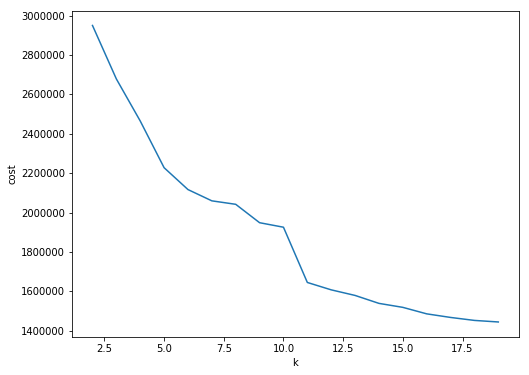

In [23]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

Looks like there is very little gain after k = 15, so we stick to that choice when processing the data set

# K means clustering using K=15

Train the machine learning model

In [24]:
k = 15
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[1.80585547 1.97573872 4.40524653 ... 0.         0.         0.        ]
[1.89741875 2.99892813 4.0800995  ... 0.         0.         0.        ]
[1.79199337 1.99577411 4.54344332 ... 0.         0.         0.        ]
[1.85970306e+00 2.94701202e+00 2.18612375e+00 ... 3.63081839e-05
 0.00000000e+00 3.63081839e-05]
[2.71778462 1.19534885 3.80315123 ... 0.         0.         0.        ]
[2.20634665 2.95822194 3.1350705  ... 0.         0.         0.        ]
[1.84312251 2.01611695 2.68500676 ... 0.         0.         0.        ]
[1.7487808  1.99768601 3.40600627 ... 0.         0.         0.        ]
[1.68683914 1.62110075 1.50277615 ... 0.         0.         0.        ]
[8.58634140e-01 1.66149925e+00 3.20637089e+00 ... 0.00000000e+00
 4.03648987e-05 0.00000000e+00]
[1.93501831 2.1751494  1.42143363 ... 0.         0.         0.        ]
[1.88299413 2.03201478 1.94314178 ... 0.         0.         0.        ]
[2.64364444 1.1494569  2.58874069 ... 0.         0.         0.      

Assign clusters to events

In [25]:
transformed = model.transform(df_kmeans).select('row_index', 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(row_index=0, prediction=8), Row(row_index=1, prediction=11), Row(row_index=2, prediction=9)]


In [34]:
df_pred = spark.createDataFrame(rows)
df_pred.show()

+---------+----------+
|row_index|prediction|
+---------+----------+
|        0|         8|
|        1|        11|
|        2|         9|
|        3|        11|
|        4|         3|
|        5|        13|
|        6|         3|
|        7|         9|
|        8|         1|
|        9|         8|
|       10|         8|
|       11|        11|
|       12|         3|
|       13|         5|
|       14|         8|
|       15|        13|
|       16|        14|
|       17|         8|
|       18|        13|
|       19|         9|
+---------+----------+
only showing top 20 rows



Join the prediction with original data 

In [ ]:
df_pred = df_pred.join(df, 'row_index')

In [36]:
df_pred.show(5)

+----------+----------+--------------------+---------+-------------------+---------------------+--------------+------------------+-----------------------+
| row_index|prediction|     features_scaled|CANCELLED|B_SCHEDULED_ARRIVAL|B_SCHEDULED_DEPARTURE|   AIRLINE_Vec|ORIGIN_AIRPORT_Vec|DESTINATION_AIRPORT_Vec|
+----------+----------+--------------------+---------+-------------------+---------------------+--------------+------------------+-----------------------+
|        26|         3|[1.25171757073918...|        0|                3.0|                  3.0|(13,[4],[1.0])|   (614,[0],[1.0])|      (618,[198],[1.0])|
|        29|        14|[1.36551007717001...|        0|                7.0|                  7.0|(13,[0],[1.0])|   (614,[0],[1.0])|       (618,[21],[1.0])|
|       474|         9|[1.36551007717001...|        0|                5.0|                  5.0|(13,[2],[1.0])|   (614,[2],[1.0])|        (618,[9],[1.0])|
|       964|        14|[1.13792506430834...|        0|                

# Evaluate clustering by computing Within Set Sum of Squared Errors.

In [44]:
wssse = model.computeCost(df_kmeans)
print("Within Set Sum of Squared Errors = " + str(wssse))

Within Set Sum of Squared Errors = 1525363.7531439266


# Clustering visualization

convert to panda dataframe

In [37]:
pddf_pred = df_pred.toPandas().set_index('row_index')
pddf_pred.head()

,prediction,features_scaled,CANCELLED,B_SCHEDULED_ARRIVAL,B_SCHEDULED_DEPARTURE,AIRLINE_Vec,ORIGIN_AIRPORT_Vec,DESTINATION_AIRPORT_Vec
row_index,,,,,,,,
26,3,"[1.2517175707391848, 3.5208695161381414, 2.170...",0,3.0,3.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
29,14,"[1.3655100771700197, 0.5029813594483059, 4.372...",0,7.0,7.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
474,9,"[1.3655100771700197, 1.0059627188966118, 3.111...",0,5.0,5.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
964,14,"[1.1379250643083498, 2.0119254377932236, 4.217...",0,7.0,6.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8589934658,12,"[2.3896426350475344, 1.5089440783449177, 2.708...",0,4.0,4.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Use 'CANCELLED', 'B_SCHEDULED_ARRIVAL', 'B_SCHEDULED_DEPARTURE' to visualize

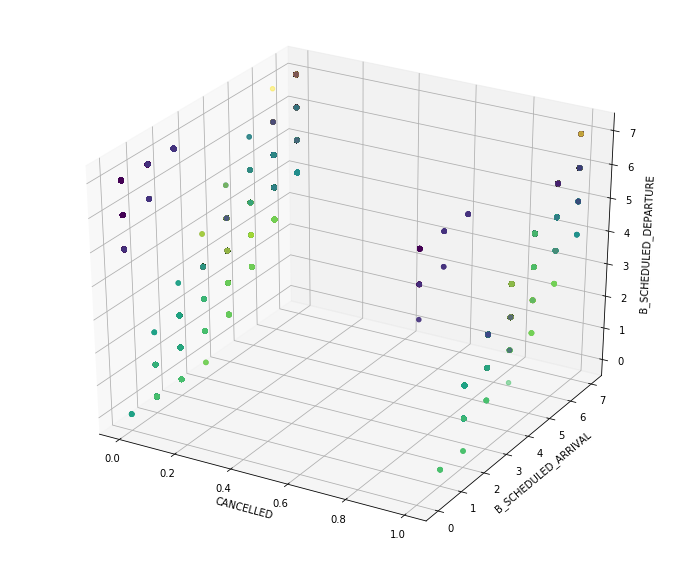

In [52]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred.CANCELLED, pddf_pred.B_SCHEDULED_ARRIVAL, pddf_pred.B_SCHEDULED_DEPARTURE, c=pddf_pred.prediction)
threedee.set_xlabel('CANCELLED')
threedee.set_ylabel('B_SCHEDULED_ARRIVAL')
threedee.set_zlabel('B_SCHEDULED_DEPARTURE')
plt.show()